In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import pandas as pd
import time

start = time.time()
class PINN:
    def __init__(self, num_inputs, layers, num_outputs, E1, A1, E2, A2, h, L, beta, Ks):
        self.model = self.build_model(num_inputs, layers, num_outputs)
        self.E1 = E1 #kN/m2
        self.A1 = A1 #m2
        self.E2 = E2
        self.A2 = A2
        self.h = h
        self.L = L
        self.beta = beta #MORA NA POCETKU DA SE SRACUNA IZ GEOMETRIJE I DA SE UNESE DOLE
        self.Ks = Ks

    def build_model(self, num_inputs, layers, num_outputs):
        activation = 'sigmoid'
        inputs = tf.keras.layers.Input(shape=(num_inputs,))
        x = inputs
        for layer in layers:
            x = tf.keras.layers.Dense(layer, activation=activation, kernel_initializer='he_normal')(x)
        outputs = tf.keras.layers.Dense(num_outputs, kernel_initializer='he_normal')(x)
        return tf.keras.models.Model(inputs=inputs, outputs=outputs)

    def exact_solution(self, x):
        # Compute the exact solution for the deflection of the beam
        #SILA P
        return self.E2*self.A2*((2*(self.L/2)*np.cos(self.beta))/(self.L*np.cos(x))-1)*(np.cos(x)*np.tan(x) + np.sin(x)) + self.Ks*(self.h - (self.L*np.tan(x)*np.tan(x))/(np.tan(x) + np.tan(x)))

    def loss(self, x, y_true):
        # Calculate the model's prediction
        y_pred = self.model(x)
        # Compute the loss as the mean squared error between the exact solution and the prediction
        return tf.reduce_mean(tf.square((y_true - y_pred)/num_train_samples)) #MORA DA SE PODELI SA BROJEM UZORKA DA BUDE MSE GRESKA

    def train(self, x_train, y_train, epochs, optimizer):
        best_loss = np.inf
        patience = 30  # Number of epochs to wait for improvement
        patience_counter = 0  # Counter to track epochs since last improvement
        
        for epoch in range(epochs):
            with tf.GradientTape() as tape:
                loss_value = self.loss(x_train, y_train)
            grads = tape.gradient(loss_value, self.model.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        
        # Early stopping logic
            if loss_value < best_loss:
                best_loss = loss_value
                patience_counter = 0  # Reset counter
                if epoch % 200 == 0:
                    print(f"Epoch {epoch}, Loss: {loss_value.numpy()}, Improvement!")
            else:
                patience_counter += 1
                if epoch % 200 == 0:
                    print(f"Epoch {epoch}, Loss: {loss_value.numpy()}, No improvement for {patience_counter} epochs.")
                
            if patience_counter >= patience:
                print(f"Stopping early after {epoch+1} epochs.")
    
    def update_parameters(self, E1, A1, E2, A2, L, h, Ks):
        # Update the physical parameters
        self.E1 = E1
        self.A1 = A1
        self.E2 = E2
        self.A2 = A2
        self.L = L
        self.h = h
        self.Ks = Ks
        
    def predict(self, x_new):
        # Use the trained model to predict the output for new input values
        return self.model.predict(x_new)

# Example usage
num_inputs = 1  # Assuming a single input feature for simplicity
layers = [40, 40, 40]  # Two hidden layers with 64 units each
num_outputs = 1  # Single output unit
E1, A1, E2, A2, h, L, beta, Ks = 2500000, 0.01, 2500000, 0.01, 1.0, 16.0, 0.124354994546761, 0
num_train_samples = 10000

# Create training data
#L_prim = np.sqrt((L/2)**2+h**2)
#beta_0 = np.arctan(h/L_prim)
step = beta/10
#x_train = np.arange(beta, -1.5*beta, -step)
x_train = 0.5*np.random.uniform(-1, 1, num_train_samples).reshape(-1, 1) #VRLO BITAN RESHAPE NA 1D NIZ ZA PINN - PAZLJIVO SA GRANICAMAAA
#x_train = -2.5 * np.random.rand(num_train_samples, 1)  # Random values

# Initialize the PINN model
pinn = PINN(num_inputs, layers, num_outputs, E1, A1, E2, A2, h, L, beta, Ks)

# Calculate the exact solution for the training data
y_train = pinn.exact_solution(x_train)

# Train the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
pinn.train(x_train, y_train, epochs=3000, optimizer=optimizer)

end = time.time()
running_time = (end - start)
print('Running Time: ', running_time, ' seconds')

Epoch 0, Loss: 0.012967260554432869, Improvement!
Epoch 200, Loss: 0.008456877432763577, Improvement!
Epoch 400, Loss: 0.005650850012898445, Improvement!
Epoch 600, Loss: 0.003872358240187168, Improvement!
Epoch 800, Loss: 0.002696345327422023, Improvement!
Epoch 1000, Loss: 0.001900361618027091, Improvement!
Epoch 1200, Loss: 0.0013543459353968501, Improvement!
Epoch 1400, Loss: 0.0009724529227241874, Improvement!
Epoch 1600, Loss: 0.0007037542527541518, Improvement!
Epoch 1800, Loss: 0.0005129656055942178, Improvement!
Epoch 2000, Loss: 0.0003754747740458697, Improvement!
Epoch 2200, Loss: 0.00027667818358168006, Improvement!
Epoch 2400, Loss: 0.00020544898870866746, Improvement!
Epoch 2600, Loss: 0.0001532196329208091, Improvement!
Epoch 2800, Loss: 0.00011512089986354113, Improvement!
Running Time:  103.52177810668945  seconds


313/313 [==============================] - 0s 854us/step


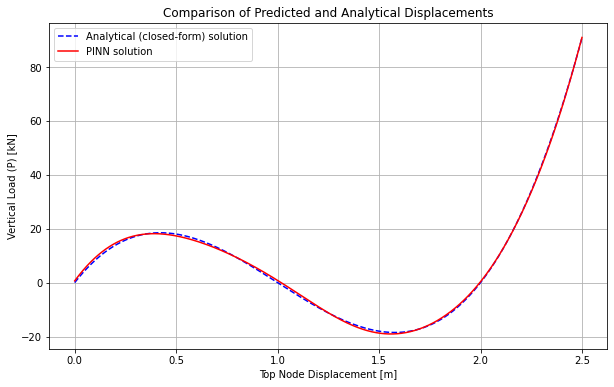

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Generate points along the beam's length
x_plot = np.linspace(0, -2.5, num_train_samples).reshape(-1, 1)  # 1000 points from 0 to L
angle_za_exact = np.linspace(beta, -1.5*beta, num_train_samples).reshape(-1, 1)
# Calculate the exact solutions for these points
y_exact = pinn.exact_solution(angle_za_exact)

# Use the trained model to predict displacements at these points
y_pred = pinn.model.predict(angle_za_exact)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(abs(x_plot), -y_exact, label='Analytical (closed-form) solution', color='blue', linestyle='--')
plt.plot(abs(x_plot), -y_pred, label='PINN solution', color='red', linestyle='-')
plt.xlabel('Top Node Displacement [m]')
plt.ylabel('Vertical Load (P) [kN]')
plt.title('Comparison of Predicted and Analytical Displacements')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
x_plot = pd.DataFrame(x_plot)
x_plot.to_excel("Shallow Truss POMERANJE Ks=0.xlsx")

y_exact = pd.DataFrame(y_exact)
y_exact.to_excel("Shallow Truss SILA EXACT Ks=0.xlsx") 

y_pred = pd.DataFrame(y_pred)
y_pred.to_excel("Shallow Truss SILA PINN Ks=0.xlsx") 

16/16 [==============================] - 0s 1ms/step


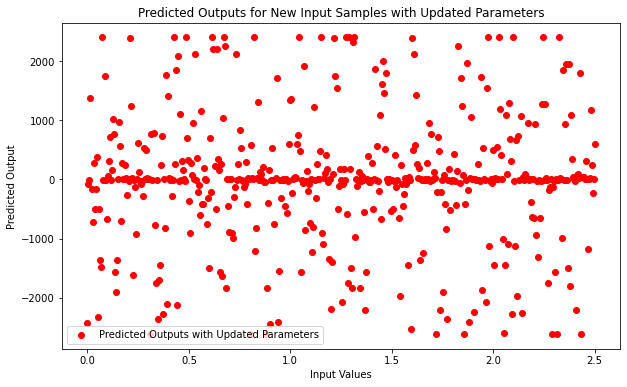

In [6]:
#TESTIRANJEEEEE - MOZDA ZEZNUTO U TEST FAZI MENJATI I MATERIJALNE KARAKTERISTIKE - ZATO CE NACIONALNA AI PLATFORMA DA UBRZA SVE
new_E1, new_A1, new_E2, new_A2, new_L, new_h, new_Ks = 3000000, 0.02, 3000000, 0.02, 20.0, 1.5, 0

# Update the model with new physical parameters
pinn.update_parameters(new_E1, new_A1, new_E2, new_A2, new_L, new_h, new_Ks)

# Continue with generating new input samples and predicting as previously shown
num_test_samples = 10000
x_test = 0.5*np.random.uniform(-1, 1, 500).reshape(-1, 1)
y_pred = pinn.predict(x_test)
x_plot = np.linspace(0, -2.5, 500).reshape(-1, 1)
# Visualization of the results
plt.figure(figsize=(10, 6))
plt.scatter(abs(x_plot), y_pred, color='r', label='Predicted Outputs with Updated Parameters')
plt.title('Predicted Outputs for New Input Samples with Updated Parameters')
plt.xlabel('Input Values')
plt.ylabel('Predicted Output')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
x_train
x_train = pd.DataFrame(x_train)
x_train.to_excel("trening set PINN.xlsx") 

In [ ]:
E = 2500000
A = 0.01
ks=E*A*h**2/(2*L**3) #IZ CRISFIELD KNJIGE NA POCETKU NAPISANE FORMULE NA KRIVAMA

In [ ]:
ks

In [ ]:
ks1=1.3*E*A*h**2/(2*L**3) #IZ CRISFIELD KNJIGE NA POCETKU NAPISANE FORMULE NA KRIVAMA

In [ ]:
ks1

In [ ]:
-y_pred

In [ ]:
-y_exact

In [ ]:
#PRERACUNAVANJE KRUTOSTI OPRUGA
#KAD ZNAM ks A TRAZIM BEZDIMENZIONALNI
ks = 1.35 #N/m
Ku = ks*h/(E1*A1*(math.sin(beta)**3)) #IZ RADA KOJI NE DELI KODOVE

In [ ]:
Ku

In [ ]:
#KAD ZNAM BEZDIMENZIONALNI A TRAZIM ks
Ku = 1.2 #bezdimenzionalno
ks = Ku*E1*A1*(math.sin(beta)**3)/h #PRERACUNATO IZ GORNJE FORMULE IZ RADA 74 KOJI NE DELI KODOVE

In [ ]:
ks #kN/m